In [1]:
%matplotlib inline
from torchvision import datasets, transforms
from data_utils import split_noniid
from torch.utils.data import Subset
from sklearn.cluster import KMeans

In [2]:
#使用mnist数据集
#trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
#train_data = datasets.MNIST('mnist', train=True, download=True, transform=trans)

In [3]:
#使用cifar10数据集
trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.CIFAR10(root='cifar10', train=True,download=True, transform=trans)

Files already downloaded and verified


In [4]:
N_CLIENTS = 20
DIRICHLET_ALPHA =1.0
import torch
import numpy as np
'''
targets = torch.tensor(train_data.targets)
idcs = []
for y in range(10):
    list = []
    for i in range(len(train_data)):
        if(targets[i]==y):
            list.append(i)
    idcs.append(list)

client_idcs = [idcs[0][0:200] + idcs[1][0:800] +idcs[2][0:500],
               idcs[3][0:200] + idcs[1][0:800] +idcs[2][0:500],
               idcs[4][0:200] + idcs[1][0:800] +idcs[2][0:500],
               idcs[5][0:200] + idcs[1][0:800] +idcs[2][0:500],
               idcs[6][0:200] + idcs[1][0:800] +idcs[2][0:500],
               idcs[7][0:200] + idcs[6][0:800] +idcs[4][0:500],
               idcs[8][0:200] + idcs[6][0:800] +idcs[4][0:500],
               idcs[9][0:200] + idcs[6][0:800] +idcs[4][0:500],
               idcs[1][0:200] + idcs[6][0:800] +idcs[4][0:500],
               idcs[2][0:200] + idcs[6][0:800] +idcs[4][0:500]] * 2
# 0 1 2 3 4
# 5 6 7 8 9


# 偶数客户端拥有0，1，2，3标签的数据
# 奇数客户端拥有4，5，6，7，8，9标签的数据
# 所以应该是偶数客户端一类，奇数客户端一类
'''
client_idcs = split_noniid(train_data,alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)


client_data = [Subset(train_data, idcs) for idcs in client_idcs]

对手写字符cifar10数据集进行处理。模拟10个客户端的场景，并根据参数为alpha=1.0的Dirichlet分布，以非独立同分布的方式将数据分配给客户端。数据的分布如下所示。

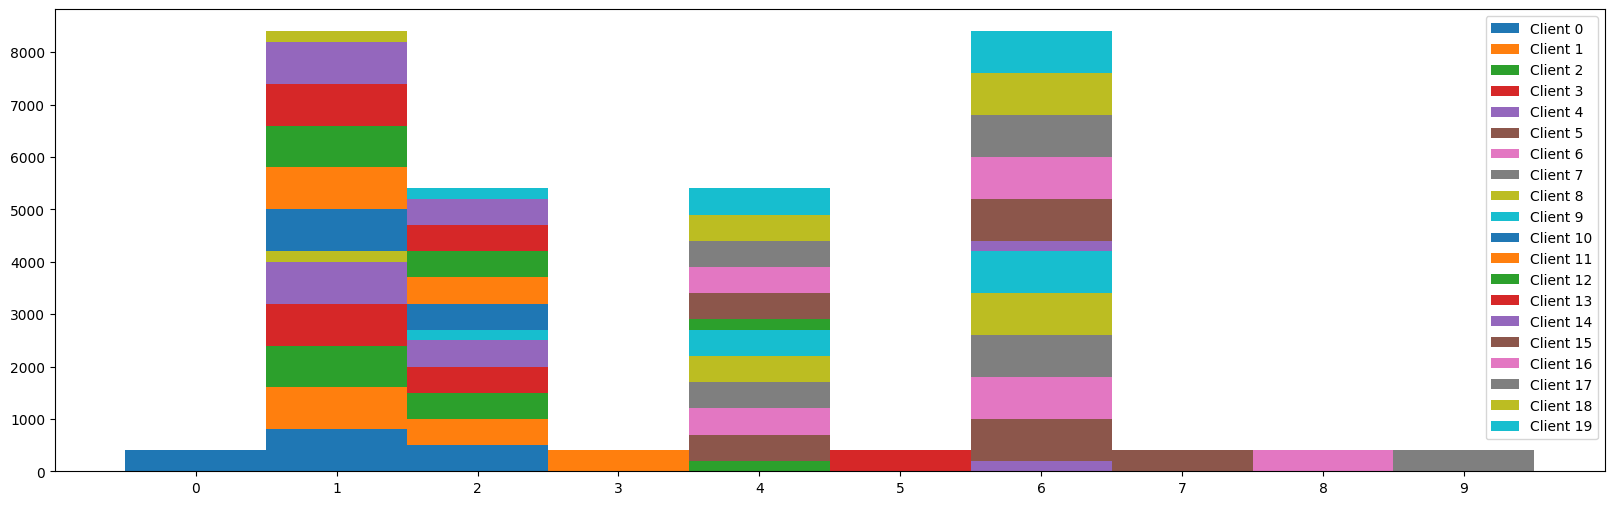

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch

'''cifar10数据集需要'''
targets = torch.tensor(train_data.targets)

mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')
plt.figure(figsize=(20,6))

"""
plt.hist([train_data.targets[idc]for idc in client_idcs], stacked=True, 
         bins=np.arange(min(train_data.targets)-0.5, max(train_data.targets) + 1.5, 1),
        label=["Client {}".format(i) for i in range(N_CLIENTS)]) 
"""

plt.hist([targets[idc]for idc in client_idcs], stacked=True, 
         bins=np.arange(min(train_data.targets)-0.5, max(train_data.targets) + 1.5, 1),
        label=["Client {}".format(i) for i in range(N_CLIENTS)]) 


plt.xticks(np.arange(10), mapp)
plt.legend()
plt.show()

In [6]:
from federated_device import Client,Server
from models import MobileNetV2,ResNet8



server_net_MobileNetV2 = MobileNetV2(num_classes=10)
server_net_ResNet8 = ResNet8(num_classes=10)

client_net_MobileNetV2 = MobileNetV2(num_classes=10)
client_net_ResNet8 =  ResNet8(num_classes=10)

#clients = [Client(client_net_CNNMnist, data, client_id=i,client_model='CNNMnist') if i<10 else Client(client_net_MLP, data, client_id=i,client_model='MLP') for i, data in enumerate(client_data)]


clients = [Client(client_net_MobileNetV2, data, client_id=i,client_model='MobileNetV2') if i<10 else Client(client_net_ResNet8, data, client_id=i,client_model='ResNet8') for i, data in enumerate(client_data)]

# 设置服务器模型和测试集，接收客户端的参数更新的平均值更新全局模型，然后在测试数据集上评估全局模型的性能，并返回评估结果。
#server_net_CNNMnist=cifar10_CNNMnist(in_channels=3,out_dim=10)
#server_net_MLP=cifar10_MLP(in_dim=3072,out_dim=10) 

#server_net_CNNMnist = CNNMnist(in_channels=1,out_dim=10)
#server_net_MLP = MLP(in_dim=784,out_dim=10)

server = Server(server_net_MobileNetV2,server_net_ResNet8)


Client 0:


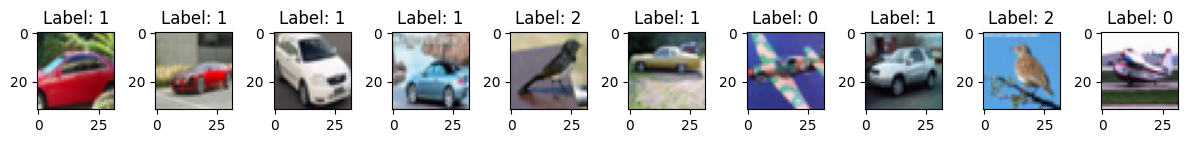

Client 6:


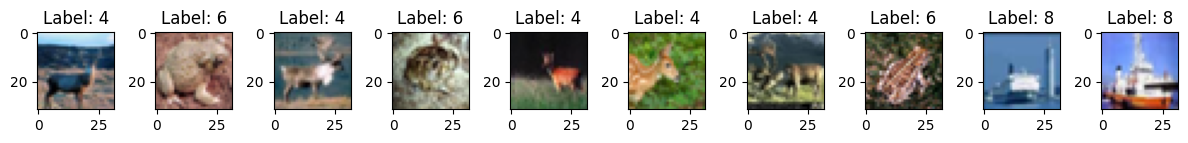

Client 10:


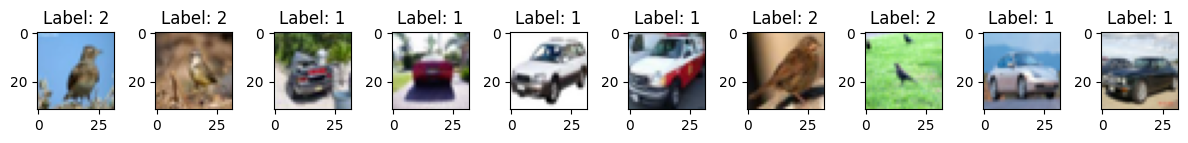

Client 15:


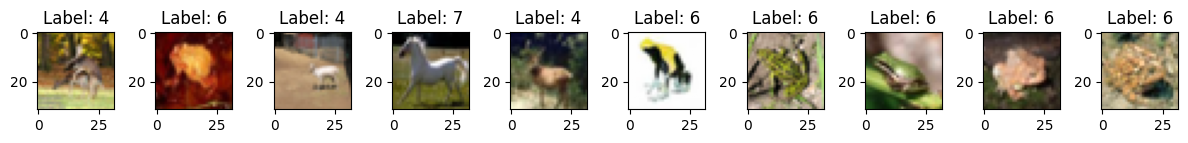

In [7]:
# 输出客户端数据，可以看到每个模型前5个客户端数据反转180度
mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')
for client in [clients[0],clients[6],clients[10],clients[15]]:
    x, y = next(iter(client.Client_train_loader))
    print("Client {}:".format(client.Client_id))
    plt.figure(figsize=(15,1))
    for i in range(10):
        plt.subplot(1,10,i+1)

        #mnist
        #plt.imshow(x[i,0].numpy(), cmap="Greys")

        '''cifar10数据集需要的操作'''
        normalized_image = (x[i].permute(1, 2, 0) - x[i].permute(1, 2, 0).min()) / (x[i].permute(1, 2, 0).max() - x[i].permute(1, 2, 0).min())
        plt.imshow(normalized_image.numpy())

        plt.title("Label: {}".format(mapp[y[i].item()]))
    plt.show()

In [8]:
# 进行自监督的预训练
server.Pretraining(pretrained=1)

正在加载MobileNet模型
正在加载ResNet8模型


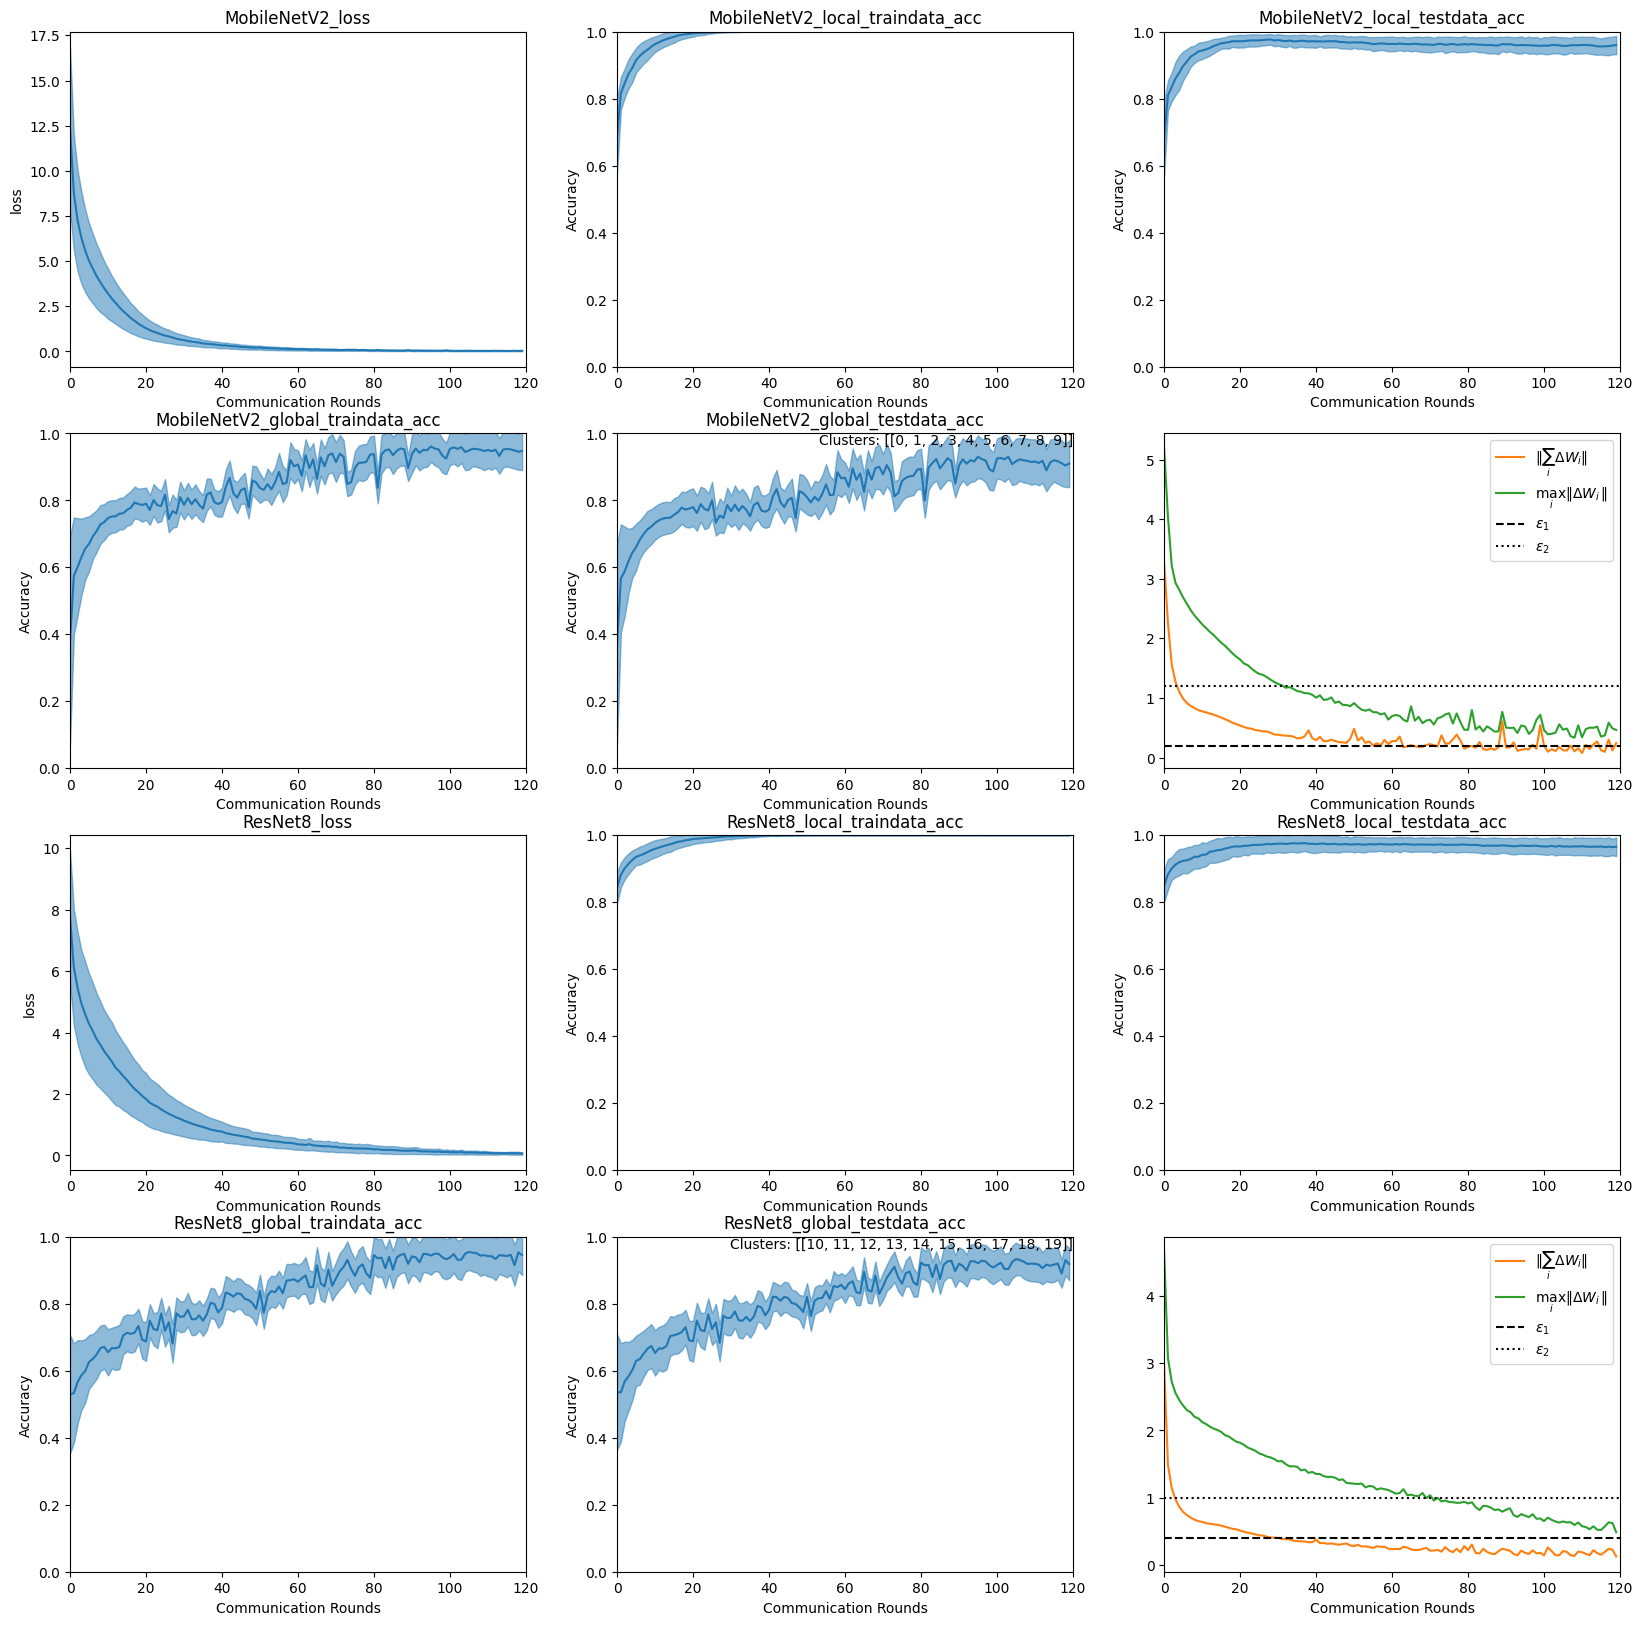

In [9]:
#设置通信轮数，默认5轮
COMMUNICATION_ROUNDS = 120

from display import show_acc
from display import ExperimentLogger

client_stats = ExperimentLogger()

#设置阈值
MobileNetV2_EPS_1 = 0.2  #+
MobileNetV2_EPS_2 = 1.2  #-

ResNet8_EPS_1 = 0.4
ResNet8_EPS_2 = 1.0

flag_r=0
flag_m=0
# 初始时，每个模型只有一个聚类，
cluster_MobileNetV2 = [[client.Client_id for client in clients if client.Client_id<10]]   #cluster_cnn = [[0,1,2,3,4,5,6,7,8,9]]
cluster_ResNet8 = [[client.Client_id for client in clients if client.Client_id>=10]] 

for round in range(COMMUNICATION_ROUNDS):    

    #1. 首先服务端确认参与的客户端数目，
    #2. 为每个客户端建立全局模型到客户端ID的Map
    #3. 得到每个客户端的分布情况，相加求和得到全局分布情况。
    participating_clients = server.select_clients(clients, frac=1.0)

    #如果是第一轮，则先与服务器同步
    if(round==0):
        '''
        #客户端获得全局类别分布，并计算客户端本地类别分布值d
        for client in participating_clients:
            client.get_classify(server)
        # 服务器获取d，和n,并且计算p
        server.get_n_d_p(participating_clients,a=0.4,b=0.1)
        '''
        
        for client in participating_clients:
            client.synchronize_with_server(server)
    
    
    #对于参与训练的客户端，在自己的数据集上开始训练，然后计算权重更新
    loss_item = []    
    train_local_acc = []
    test_local_acc = []
    for client in participating_clients:
        
        loss,train_acc,test_acc = client.compute_weight_update(epochs=5)
        loss_item.append(loss)
        train_local_acc.append(train_acc)
        test_local_acc.append(test_acc)

    cluster_indices_MobileNetV2 = []    #设置新的聚类集合
    cluster_indices_ResNet8 = []    #设置新的聚类集合
    
    for idc in cluster_MobileNetV2:  #遍历每个客户端，查看是否达到分离条件。
    # 权重更新二范数的平均值和最大值
        MobileNetV2_max_norm = server.compute_max_update_norm([clients[i] for i in idc])
        MobileNetV2_mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])
        #if MobileNetV2_mean_norm<MobileNetV2_EPS_1 and MobileNetV2_max_norm>MobileNetV2_EPS_2 and len(idc)>2 and round>40 and flag_m==0:#分离条件
        if flag_m==0 and round>130:#分离条件
            flag_m=1
            sim1 = server.compute_pairwise_similarities(participating_clients[0:10])

            #当达到分离条件时，我们需要保存当前聚类内部的全局模型，以及客户端测试的准确度。
            #server.cache_model(idc, server.mapping[idc[0]], clients_acc_CNN)
            server.cache_model(idc, clients_acc)
            #c1, c2 = server.cluster_clients(similarities[idc][:,idc]) #分成两类

            '''       K-means     '''
            #keans聚类方法
            kmeans = KMeans(n_clusters=2,n_init=10)  # 设置聚类的簇数
            kmeans.fit(sim1)
            labels = kmeans.labels_
            c1 = []
            c2 = []
            for i in range(len(labels)):
                if labels[i] == 0:
                    c1.append(i)
                else:
                    c2.append(i)
            
            c1=np.array(c1)
            c2=np.array(c2)
            print('round_sim1: ',round,'\t','c1/c2: ',c1,'\t',c2)
        
            '''        K-means                '''
           
           
            cluster_indices_MobileNetV2 += [c1, c2]
           
            client_stats.log({"split_MobileNetV2" : round})
        else:
            # 不聚类，则仍然视为一个整体
            cluster_indices_MobileNetV2 += [idc]

    for idc in cluster_ResNet8:  #遍历每个客户端，查看是否达到分离条件。
    # 权重更新二范数的平均值和最大值
        ResNet8_max_norm = server.compute_max_update_norm([clients[i] for i in idc])
        ResNet8_mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])
        #if ResNet8_mean_norm<ResNet8_EPS_1 and ResNet8_max_norm>ResNet8_EPS_2 and len(idc)>2 and round>40 and flag_r==0:#分离条件
        if flag_r==0 and  round>130:#分离条件

            sim2 = server.compute_pairwise_similarities(participating_clients[10:20])

            flag_r=1
            #acc_clients是模型准确率，
            server.cache_model(idc,clients_acc)
            #c1, c2 = server.cluster_clients(similarities[idc][:,idc]) #因为我们计算的是模型内部所有客户端的余弦相似性，所以需要挑出来当前聚类内部客户端的相似性。
     
            #keans聚类方法
            kmeans = KMeans(n_clusters=2,n_init=10)  # 设置聚类的簇数
            kmeans.fit(sim2)
            labels = kmeans.labels_
            c3 = []
            c4 = []
            for i in range(len(labels)):
                if labels[i] == 0:
                    c3.append(i+10)
                else:
                    c4.append(i+10)
            
            c3=np.array(c3)
            c4=np.array(c4)
            print('round_sim2: ',round,'\t','c3/c4: ',c3,'\t',c4)
        
            cluster_indices_ResNet8 += [c3, c4]
            client_stats.log({"split_ResNet8" : round})
        else:
            # 不聚类，则仍然视为一个整体
            cluster_indices_ResNet8 += [idc]
    
    cluster_MobileNetV2 = cluster_indices_MobileNetV2
    cluster_ResNet8 = cluster_indices_ResNet8
    
    #得到聚类后的客户端
    client_MobileNetV2_clusters = [[clients[i] for i in idcs] for idcs in cluster_MobileNetV2]
    client_ResNet8_clusters = [[clients[i] for i in idcs] for idcs in cluster_ResNet8]
    
    #上传客户端权重更新到服务器，进行聚合。
    server.aggregate_clusterwise(client_MobileNetV2_clusters,client_ResNet8_clusters)

    #对于参加训练的客户端，与服务器同步，接受最新的全局模型。
    for client in participating_clients:
        client.synchronize_with_server(server)
        
    #用最新的模型进行在训练集评估（即使有多个模型，但评估是求准确度的平均值，只是这里每个客户端的模型可能不同）
    clients_acc = [client.eval() for client in participating_clients]

    #用最新的模型进行评估（即使有多个模型，但评估是求准确度的平均值，只是这里每个客户端的模型可能不同）
    clients_train_acc = [client.train_eval() for client in participating_clients]
    
    client_stats.log({'MobileNetV2_local_test_acc':test_local_acc[0:10],'ResNet8_local_test_acc':test_local_acc[10:20],
                      'MobileNetV2_local_acc':train_local_acc[0:10],'ResNet8_local_acc':train_local_acc[10:20],
                      'MobileNetV2_loss':loss_item[0:10],'ResNet8_loss':loss_item[10:20],
                      'clients_train_MobileNetV2': clients_train_acc[0:10],'clients_train_ResNet8': clients_train_acc[10:20],
                      "clients_acc_MobileNetV2" : clients_acc[0:10],"clients_acc_ResNet8" : clients_acc[10:20], 
                      "MobileNetV2_mean_norm" : MobileNetV2_mean_norm, "MobileNetV2_max_norm" : MobileNetV2_max_norm,
                      "ResNet8_mean_norm" : ResNet8_mean_norm, "ResNet8_max_norm" : ResNet8_max_norm,
                      "rounds" : round, "cluster_MobileNetV2" : cluster_MobileNetV2,"cluster_ResNet8":cluster_ResNet8})
    show_acc(client_stats, COMMUNICATION_ROUNDS,MobileNetV2_EPS_1,MobileNetV2_EPS_2,ResNet8_EPS_1,ResNet8_EPS_2)

for idc in cluster_MobileNetV2:     
    server.cache_model(idc, clients_acc)
for idc in cluster_ResNet8:
    server.cache_model(idc, clients_acc)


In [10]:
# 评估未聚类模型和聚类后的模型的准确度
results = np.zeros([20, len(server.model_cache)])
for i, (idcs, accs) in enumerate(server.model_cache):
    results[idcs, i] = np.array(accs)


In [11]:
#画图
import pandas as pd
frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i) 
                                                    for i in range(results.shape[1]-1)],
            index = ["Client {}".format(i) for i in range(results.shape[0])])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
frame.T.style.apply(highlight_max)

,Client 0,Client 1,Client 2,Client 3,Client 4,Client 5,Client 6,Client 7,Client 8,Client 9,Client 10,Client 11,Client 12,Client 13,Client 14,Client 15,Client 16,Client 17,Client 18,Client 19
FL Model,0.783333,0.820000,0.920000,0.830000,0.903333,0.953333,0.960000,0.966667,0.996667,0.966667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Model 0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.833333,0.866667,0.923333,0.866667,0.933333,0.906667,0.960000,0.943333,0.996667,0.960000
